# Title

# Overview

Overview here

# Group Members

 - Ivan Jin (A14880280)
 - Hongsheng Xie (A14794772)
 - Tong Wang (A13713688)
 - Yinxuan Du (A15873678)
 - Yuchen Zhang (A16151373)

# Research Question

Research Question Here

# Background & Prior Work

BG + Prior work here

# Hypothesis

Hypothesis here

# Datasets

### 1. Airline Delay and Cancellation Data, 2009 - 2018
- Content: US domestic flight delay data
- Columns of interest: 
- \# of observations: 6429338 rows for year 2009
- Source: https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018
- Function: main outcome variable

### 2. FILL ME ACCORDING TO OUR DATASET!
- Content:
- Columns of interest: 
- \# of observations: 
- Source: 
- Function:

# Setup

In [1]:
import pandas as pd
import numpy as np
from numpy import nan as Nan
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

from IPython.display import Image, display

import requests
from string import digits
import wget 
import glob
import time

import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import patsy
import psutil

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import plotly.figure_factory as ff
import xml.etree.ElementTree as ET # to read one dataset in XML format

# Data Cleaning

### Overview

To answer our question, we need to clean and aggregate our main outcome variable (delay, crash) and our predictors by airports. The goal of data cleaning is to get two dataframes that have airport code as index:
 - 1.Y 
     - columns
         - average_departure_delay - average delay of all flights originated from this airport 
         - average_arrival_delay - average delay of all flights arriving at this airport
         - average_cancelled - average cancel rate of all flights originated from this airport
         - average_diverted - average diverted rate of all flights arriving at this airport
 - 2.X 
     - columns
         - code4 - 4 digit airport code
         - city_name - name of the city that located near the airport
         - city_id - index of this city in uscities_df
         - latitude - latitude of the airport
         - longitude - longitude of the airport
         - altitude_ft - altitude of the airport
         - temp_avg - 2018-2019 average tempreature of the county contining the airport
         - pcp_avg - 2018-2019 average precipitation of the county contining the airport
         - strike_avg - year-average number bird strike (may not caused damage)
         - damage_avg - year-average number of bird strike that caused damage
         - city_population - population the city that located near the airport
         - enplanements - enplanements of the city that located near the airport
         - length_ft_sum - sum of length of all runways
         - width_ft_avg - average width of all runways
         - num_runways - number of runways

### Cleaning - Y 

#### 2.1 Delay dataset - departure/ arrival delay + cancel / divert rate 
From `A Pleasant Flight.ipynb` (now in the folder `previous_codes`)

In [104]:
delay_2018_df = pd.read_csv("datasets/original/delay/2018.csv")
delay_2018_df = delay_2018_df[["ORIGIN","DEST","DEP_DELAY","TAXI_OUT","CANCELLED","DISTANCE","ARR_DELAY","TAXI_IN","DIVERTED"]] # columns of interest

First,we check the distribution of missing values:

In [3]:
delay_2018_df.isna().sum()

ORIGIN            0
DEST              0
DEP_DELAY    117234
TAXI_OUT     115830
CANCELLED         0
DISTANCE          0
ARR_DELAY    137040
TAXI_IN      119246
DIVERTED          0
dtype: int64

There are missing values for delay columns. However, we discovered that 95% of the missing value have "CANCALLED" == 1. It is logical to have missing delay value when the flight is never done. For these flight have already contributed to the cancel rate feature, thus should not have a effect on the delay. Since we are using the .mean() function, which will ignore all nan values, we left these rows unchanged. Same for diverted, when there shouldn't be a arrival delay because the flight is not arriving at the scheduled airport. We kept them because we can have a more accurate total departure/arrival number. In this way we have only 4000 rows that we can't explain the reason behind missing value. Since we have 7213446 rows in total, 4000 is a acceptable amount of missing. We also kept it for accurate total departure/arrival number.
We then calculated departure_delay, arrival_delay and other columns of interest. 

In [4]:
# DEPARTURE
unpleasant_2018_departure = pd.DataFrame()
unpleasant_2018_departure['total_departure'] = delay_2018_df.loc[:,["ORIGIN"]].groupby('ORIGIN').size()
unpleasant_2018_departure[["average_departure_delay","average_departure_taxi"]] = delay_2018_df.loc[:,["ORIGIN","DEP_DELAY","TAXI_OUT"]].groupby('ORIGIN').mean()
unpleasant_2018_departure['average_departure_cancelled'] = delay_2018_df.loc[:,["ORIGIN","CANCELLED"]].groupby('ORIGIN').mean()
unpleasant_2018_departure['averge_departure_distance'] = delay_2018_df.loc[:,["ORIGIN","DISTANCE"]].groupby('ORIGIN').mean()
    
#ARRIVAL
unpleasant_2018_arrival = pd.DataFrame()
unpleasant_2018_arrival['total_arrival'] = delay_2018_df.loc[:,["DEST"]].groupby('DEST').size()
unpleasant_2018_arrival[["average_arrival_delay","average_arrival_taxi"]] = delay_2018_df.loc[:,["DEST","ARR_DELAY","TAXI_IN"]].groupby('DEST').mean()
unpleasant_2018_arrival['average_arrival_diverted'] = delay_2018_df.loc[:,["DEST","DIVERTED"]].groupby('DEST').mean()
unpleasant_2018_arrival['averge_arrival_distance'] = delay_2018_df.loc[:,["DEST","DISTANCE"]].groupby('DEST').mean()

#Add log to total_departure and total_arrival 
unpleasant_2018_departure['total_departure_lg10'] = unpleasant_2018_departure['total_departure'].apply(np.log10)
unpleasant_2018_arrival['total_arrival_lg10'] = unpleasant_2018_arrival['total_arrival'].apply(np.log10)

#Merge departure and arrival
delay_2018_df = unpleasant_2018_departure.merge(unpleasant_2018_arrival,left_index=True,right_index=True)
delay_2018_df.index.names = ["airport_code"]

### Scope:
We are interested in airports in **U.S. mainland** and with at least **10** departures. We dropped those have <10 departures and state Hawaii and Alaska later.

In [5]:
delay_2018_df = delay_2018_df[delay_2018_df["total_departure"]>=10]

# Main outcome variable
Y = delay_2018_df.loc[:,["average_departure_delay","average_arrival_delay","average_departure_cancelled","average_arrival_diverted"]]

#
unpleasant_airport_code_df = delay_2018_df[[]]

### Cleaning - X

#### 2.2 Delay dataset - total arrival / departure + average departure / arrival distance + departure / arrival taxi time
From `A Pleasant Flight.ipynb` (now in the folder `previous_codes`), Cleaned above

In [6]:
# extract X features
X = pd.DataFrame()
X[["total_departure","total_arrival","total_departure_lg10","total_arrival_lg10","averge_departure_distance","averge_arrival_distance","average_departure_taxi","average_arrival_taxi"]] \
= delay_2018_df.loc[:,["total_departure","total_arrival","total_departure_lg10","total_arrival_lg10","averge_departure_distance","averge_arrival_distance","average_departure_taxi","average_arrival_taxi"]] 

#### 2.3 U.S. Airport dataset - city name, latitude, longitude, altitude
From `A Pleasant Flight.ipynb` (now in the folder `previous_codes`).

Clean `datasets/original/airport/airport-extended.csv`. Generate `airport_loc_df` with column names city_name, latitude, longitude, altitude_ft. Export `airport_loc.csv`.

In [7]:
airport_loc_df = pd.read_csv("datasets/original/airport/airports-extended.csv")

In [8]:
def clean_city_name(input_city):
    original = input_city
    input_city = str(input_city)
    input_city = input_city.strip()
    input_city = input_city.lower()
    
    input_city = input_city.replace(".","")
    input_city = input_city.replace("\\\\","")
    input_city = input_city.replace("-"," ")
    input_city = input_city.replace(" - "," ")
    input_city = input_city.replace("saint ","st")
    input_city = input_city.replace("east ","")
    input_city = input_city.replace("west ","")
    
    input_city = input_city.translate({ord(k): None for k in digits})
    
    if ('/' in input_city):
        input_city = input_city[:input_city.find('/')] # in case city have muitiple names like "cityname1/cityname2"
    if ('(' in input_city):
        input_city = input_city[:input_city.find('(')] # Same as above
    if (',' in input_city):
        input_city = input_city[:input_city.find(',')] 
    input_city = input_city.strip()   
    if (' ' in input_city):
        temp=input_city.find(' ')
        if (temp > 2):
            input_city = input_city[:input_city.find(' ')]
        else:
            if (input_city.find(' ',temp+1) != -1):
                input_city = input_city[temp+1:input_city.find(' ',temp+1)]
            else:
                input_city = input_city[temp+1:]
    input_city = input_city.strip()
    try:
        assert len(input_city) > 2
        assert input_city.replace(" ","").replace("'","").isalpha()
    except:
        #print("This city name is prehaps incorrect: ",original,input_city,len(original))
        1+1
    return input_city

In [9]:
airport_loc_df.columns = ["ID","name","city_name","country","airport_code","code4","latitude","longitude","altitude_ft","UTC_offset","DST","timezone","type","information_source"]
airport_loc_df = airport_loc_df.loc[:,["city_name","country","airport_code","code4", "latitude","longitude","altitude_ft"]] # add code4 since we need to use it to get runways data --YD 03/05
airport_loc_df = airport_loc_df[airport_loc_df["country"]=="United States"] # reduce dataframe size
airport_loc_df = airport_loc_df.loc[:,["city_name","airport_code","code4", "latitude","longitude","altitude_ft"]]# We don't need the country column again
airport_loc_df = airport_loc_df[airport_loc_df["airport_code"]!="\\N"] # remove NAN in index
airport_loc_df = airport_loc_df.set_index("airport_code")
airport_loc_df["city_name"] = airport_loc_df["city_name"].apply(clean_city_name)# clean city name

# store cleaned data
airport_loc_df.to_csv("datasets/cleaned/airport_loc.csv")

#### 2.4 U.S. Cities dataset - city name, FIPS, population
Clean `datasets/original/city/uscities.csv`.

In [10]:
us_cities_df = pd.read_csv("datasets/original/city/uscities.csv")

# Kept latitude and longitude to differentiate cities with same name
us_cities_df = us_cities_df[["city","state_id","county_fips","county_name","population","lat","lng"]] 
us_cities_df = us_cities_df.rename(columns = {"city":"city_name"})                                              
us_cities_df["fips"] = us_cities_df["county_fips"]

def get_county_code(input_county):
    return int(input_county) % 1000

us_cities_df["county_fips"] = us_cities_df["county_fips"].apply(get_county_code)
us_cities_df["city_name"] = us_cities_df["city_name"].apply(clean_city_name)

#### 2.5 Merge step 2.2 - 2.4
Merge `unpleasant_airport_code_df`(empty dataframe with only `airport_code` as index) and `airport_loc_df` by `airport_code` to select the airport we need. Then merge it with `us_cities_df` by `city_name`. Rank duplicaited city name by abs(delta_latitude) + abs(delta_longitude), assert the number is < 1.5 deg and select the city with smallest error.

Generate `city_search_df` for scraping climate data.

In [11]:
airport_prop_df = unpleasant_airport_code_df.merge(airport_loc_df,how='inner',left_index=True,right_index=True)

city_search_df = pd.DataFrame(columns=["airport_code","state_id","county_id","city_id","fips","population"])
for ind,row in airport_prop_df.iterrows():
    city = row["city_name"]
    target_lat = row["latitude"]
    target_lng = row["longitude"]
    try:      
        target_cities = us_cities_df[us_cities_df["city_name"]==city]
        
        if not (target_cities.shape[0] == 1): # If there are multiple city with same name
            def calc_dis(input_):
                err = abs(target_lat - input_["lat"]) + abs(target_lng - input_["lng"])
                return err
            target_cities.loc[:,"error"] = (target_cities.apply(calc_dis,axis=1))
            target_city = target_cities.sort_values(by="error").iloc[0]
            
            assert target_city["error"] < 1.5 # assert the error should be <1.5 degs ~ 40 miles.
            
            target_city = target_city.drop(["error"])
        elif (target_cities.shape[0] >= 1):
            target_city = target_cities.iloc[0]
        
        county = str(target_city["county_fips"])
        if (len(county)==1):
            county = "00" + county
        elif (len(county)==2):
            county = "0" + county

        city_search_df = city_search_df.append({"airport_code":ind,"state_id":target_city["state_id"],"county_id":county,"city_id":target_city.name,"fips":target_city["fips"],"population":target_city["population"]},ignore_index=True)        
    except:
        try:
            def calc_dis(input_):
                err = abs(target_lat - input_["lat"]) + abs(target_lng - input_["lng"])
                return err
            us_cities_df_copy = us_cities_df
            us_cities_df_copy.loc[:,"error"] = (us_cities_df.apply(calc_dis,axis=1))
            target_city = us_cities_df_copy.sort_values(by="error").iloc[0]
            assert target_city["error"] < 1.5
            county = str(target_city["county_fips"])
            if (len(county)==1):
                county = "00" + county
            elif (len(county)==2):
                county = "0" + county
            city_search_df = city_search_df.append({"airport_code":ind,"state_id":target_city["state_id"],"county_id":county,"city_id":target_city.name,"fips":target_city["fips"],"population":target_city["population"]},ignore_index=True)
        except:
            print("No data for ",city)
            city_search_df = city_search_df.append({"airport_code":ind,"state_id":np.nan,"county_id":np.nan,"city_id":np.nan,"fips":np.nan,"population":np.nan},ignore_index=True)

#special case for DC
for ind,row in city_search_df.iterrows():
    if (row["airport_code"]=="DCA"):
        city_search_df.iloc[ind]["state_id"]="MD"
        city_search_df.iloc[ind]["county_id"]="511"

# Remove Hawaii and Alaska
city_search_df = city_search_df[(city_search_df["state_id"]!="HI") & (city_search_df["state_id"]!="AK")]
airport_prop_df = airport_prop_df.merge(city_search_df.set_index("airport_code").loc[:,["city_id","fips","population"]],left_index=True,right_index=True)

#### 2.6 Download and process temperature and precipitation data
From https://www.ncdc.noaa.gov

In [12]:
def download_climate_data(state,county,year):
    save_path = "datasets/original/weather/"
    fname = state + county + "_" + str(year) + ".csv"
    if (len(glob.glob(save_path + fname))==0):
        URL = "https://www.ncdc.noaa.gov/cag/county/time-series/{}-{}-{}-all-1-2000-2020.csv?base_prd=true&begbaseyear=1901&endbaseyear=2000".format(state,county,"tavg")
        r = requests.get(URL)
        file = wget.download(URL,out=save_path + "tavg/tavg_" + fname)
        URL = "https://www.ncdc.noaa.gov/cag/county/time-series/{}-{}-{}-all-1-2000-2020.csv?base_prd=true&begbaseyear=1901&endbaseyear=2000".format(state,county,"pcp")
        r = requests.get(URL)
        file = wget.download(URL,out=save_path + "pcp/pcp_" + fname)

        tavg_df = pd.read_csv(save_path + "tavg/tavg_" + fname).iloc[4:]
        tavg_df.columns=["date","tavg","comp"]
        tavg = tavg_df.set_index("date")["tavg"]

        pcp_df = pd.read_csv(save_path + "pcp/pcp_" + fname).iloc[4:]
        pcp_df.columns=["date","pcp","comp"]
        pcp = pcp_df.set_index("date")["pcp"]

        pd.concat([tavg, pcp], axis=1).to_csv(save_path + fname)
        time.sleep(1) # not requesting too frequently

In [13]:
city_search_df.head()

,airport_code,state_id,county_id,city_id,fips,population
0,ABE,PA,077,10988,42077,682899
1,ABI,TX,441,5333,48441,114964
2,ABQ,NM,001,3742,35001,758523
3,ABR,SD,013,28674,46013,28264
4,ABY,GA,095,17309,13095,90515


In [14]:
counter = 0
# Download data according to city_search_df
for ind,row in city_search_df.iterrows():
    try:
        download_climate_data(row["state_id"],row["county_id"],2018)
        download_climate_data(row["state_id"],row["county_id"],2019)
    except:
        print(row)
    counter+=1
    print("progress: {:.2f}%   Just done: {}".format(100 * counter / city_search_df.shape[0],row["airport_code"]),end="\r")

# Process downloaded data
temp_pcp_df = pd.DataFrame(columns=["airport_code","temp_avg","pcp_avg"])
for ind,row in city_search_df.iterrows():
    state = row["state_id"]
    county = row["county_id"]
    save_path = "datasets/original/weather/"
    years = [2018,2019]
    
    try:
        tavg = 0
        pcp = 0
        for year in years:
            fname = state + county + "_" + str(year) + ".csv"
            temp_pcp = pd.read_csv(save_path + fname)
            tavg += temp_pcp.mean()["tavg"]
            pcp += temp_pcp.mean()["pcp"]
        tavg /= len(years)
        pcp /= len(years)
        
        temp_pcp_df = temp_pcp_df.append({"airport_code":row["airport_code"],"temp_avg":tavg,"pcp_avg":pcp},ignore_index=True)
        
    except:
        temp_pcp_df = temp_pcp_df.append({"airport_code":row["airport_code"],"temp_avg":np.nan,"pcp_avg":np.nan},ignore_index=True)

In [15]:
airport_prop_df = airport_prop_df.merge(temp_pcp_df.set_index("airport_code"),left_index=True,right_index=True)
airport_prop_df.head()

,city_name,code4,latitude,longitude,altitude_ft,city_id,fips,population,temp_avg,pcp_avg
airport_code,,,,,,,,,,
ABE,allentown,KABE,40.652100,-75.440804,393,10988,42077,682899,51.902490,4.161037
ABI,abilene,KABI,32.411301,-99.681900,1791,5333,48441,114964,64.488797,2.131411
ABQ,albuquerque,KABQ,35.040199,-106.609001,5355,3742,35001,758523,54.316598,0.928465
ABR,aberdeen,KABR,45.449100,-98.421799,1302,28674,46013,28264,43.304149,1.796141
ABY,albany,KABY,31.535500,-84.194504,197,17309,13095,90515,66.578008,4.069336


#### 2.7 Bird Strike dataset - strike_average, damage_average
Clean `datasets/original/airports/Bird Strikes.xlsx`. Merge `bird_strike_avg_df` and `unpleasant_airport_code_df` to get `bird_strike_final_df`. Export it as `bird_strike.csv`.There's no airport code in `Bird Strikes.xlsx`, so additional dataset that contains airport name and airport code is used to link them.

In [16]:
bird_strike_df = pd.read_excel("datasets/original/airport/Bird Strikes.xlsx") #data6
airport_name_df = pd.read_excel("datasets/original/airport/airportcode.xlsx") #data7 
bird_strike_df = bird_strike_df[["Airport: Name", "Effect: Indicated Damage"]]
bird_strike_df = bird_strike_df.rename(columns = {"Airport: Name": "airport_name", "Effect: Indicated Damage":"bird_strike_effect"})
bird_strike_df = bird_strike_df.dropna()
bird_strike_df = bird_strike_df.reset_index(drop = True)
bird_strike_df.head()

,airport_name,bird_strike_effect
0,LAGUARDIA NY,Caused damage
1,DALLAS/FORT WORTH INTL ARPT,Caused damage
2,LAKEFRONT AIRPORT,No damage
3,SEATTLE-TACOMA INTL,No damage
4,NORFOLK INTL,No damage


In [17]:
airport_name_df = airport_name_df.dropna()
airport_name_df = airport_name_df.reset_index(drop = True)
airport_name_df.head()

,airport_code,airport_name
0,ABE,Lehigh Valley International
1,ABI,Abilene Regional Airport
2,ABQ,Albuquerque International Sunport
3,ABY,Southwest Georgia Regional
4,ACK,Nantucket Memorial


In [18]:
def standardize_airport_name(string):
    
    string = string.lower()
    string = string.strip()
    if 'intl' in string:
        string = string.replace('intl', '')
    if 'arpt' in string:
        string = string.replace('arpt', '')
    if 'regional' in string:
        string = string.replace('regional', '')
    if 'airport' in string:
        string = string.replace('airport', '')
    if 'sunport' in string:
        string = string.replace('sunport', '')
    if 'international' in string:
        string = string.replace('international', '')
    if 'intercontinental' in string:
        string = string.replace('intercontinental', '')
    else:
        output = string
        
    string = string = string.strip()
    
    return string

In [19]:
bird_strike_df['airport_name'] = bird_strike_df['airport_name'].apply(standardize_airport_name)
airport_name_df['airport_name'] = airport_name_df['airport_name'].apply(standardize_airport_name)

def check_strike (string):
    return 1

def check_damage (string):
    if 'Caused' in string:
        output = 1
    else:
        output = 0
    return output

bird_strike_df['strike'] = bird_strike_df['bird_strike_effect'].apply(check_strike)
bird_strike_df['damage'] = bird_strike_df['bird_strike_effect'].apply(check_damage)
bird_strike_df.head()

,airport_name,bird_strike_effect,strike,damage
0,laguardia ny,Caused damage,1,1
1,dallas/fort worth,Caused damage,1,1
2,lakefront,No damage,1,0
3,seattle-tacoma,No damage,1,0
4,norfolk,No damage,1,0


In [20]:
grouped_strike = bird_strike_df.groupby('airport_name').agg({'strike':['sum']})
grouped_strike = grouped_strike.reset_index()
grouped_damage = bird_strike_df.groupby('airport_name').agg({'damage':['sum']})

bird_strike_sum_df = pd.merge(grouped_strike, grouped_damage, on='airport_name')
bird_strike_sum_df.columns = ['airport_name', 'strike_sum','damage_sum']

bird_strike_avg_df = pd.merge(airport_name_df, bird_strike_sum_df, on='airport_name')

def average_sum(input):
    output = input/(2011 - 2000 + 1)
    return output

bird_strike_avg_df['strike_avg'] = bird_strike_avg_df['strike_sum'].apply(average_sum)
bird_strike_avg_df['damage_avg'] = bird_strike_avg_df['damage_sum'].apply(average_sum)
bird_strike_avg_df = bird_strike_avg_df.drop(columns = ['strike_sum', 'damage_sum'])

bird_strike_avg_df= bird_strike_avg_df.drop(columns = ["airport_name"])
bird_strike_avg_df.head()

,airport_code,strike_avg,damage_avg
0,ABE,5.250000,0.166667
1,ABI,0.750000,0.083333
2,ABQ,6.833333,0.250000
3,ABY,0.416667,0.083333
4,ACK,0.583333,0.083333


We later need to merge this dataframe to `airport_prop_df`. However, not all airports have bird strike. Therefore, we used a right merge(that kept all rows from `airport_prop_df`) and filled nan with 0. 

In [21]:
bird_strike_final_df = pd.merge(bird_strike_avg_df, unpleasant_airport_code_df.reset_index(), how='right')
# unpleasant_airport_code_df have the same index as airport_prop_df
bird_strike_final_df = bird_strike_final_df.fillna(0)
bird_strike_final_df = bird_strike_final_df.set_index("airport_code")
bird_strike_final_df.head()

,strike_avg,damage_avg
airport_code,,
ABE,5.250000,0.166667
ABI,0.750000,0.083333
ABQ,6.833333,0.250000
ABY,0.416667,0.083333
ACK,0.583333,0.083333


#### 2.8 Runways dataset - runway length, width, count
Clean `datasets/original/airport/runways.csv`.

In [22]:
airport_runways_df=pd.read_csv("datasets/original/airport/runways.csv")
airport_runways_df = airport_runways_df.rename(columns = {"airport_ident":"code4"})
airport_runways_df = pd.merge(airport_runways_df, airport_loc_df.reset_index(), how = 'inner', on = 'code4')
airport_runways_df = airport_runways_df[["code4", "airport_code", "length_ft", "width_ft"]]
airport_runways_df.head()

,code4,airport_code,length_ft,width_ft
0,07FA,OCA,4500.0,70.0
1,5A8,WKK,2040.0,80.0
2,HI07,WKL,26.0,26.0
3,K0V4,0V4,3798.0,60.0
4,K19S,19S,2300.0,100.0


In [23]:
runways_sum_df = airport_runways_df.groupby(['airport_code']).sum()
runways_mean_df = airport_runways_df.groupby(['airport_code']).mean()
runways_count_df = airport_runways_df.groupby(['airport_code']).count()
runway_final_df = runways_sum_df["length_ft"].to_frame().join(runways_mean_df["width_ft"].to_frame())
runway_final_df["count"] = runways_count_df["length_ft"]
runway_final_df.columns = ["length_ft_sum", "width_ft_avg","runway_count"]

runway_final_df.head()

,length_ft_sum,width_ft_avg,runway_count
airport_code,,,
0V4,3798.0,60.000000,1
19S,6800.0,80.000000,2
23M,3200.0,60.000000,1
2A5,3800.0,40.000000,1
2H0,9948.0,158.333333,3


#### 2.9 enplanements dataset - enplanements
Clean `commercial_service_enplanements.xlsx`.

In [24]:
enplanements_df = pd.read_excel('datasets/original/city/commercial_service_enplanements.xlsx')
enplanements_df = enplanements_df.rename(columns = {"Locid":"airport_code", "% Change":"enplanement_change", "CY 18 Enplanements":"enplanements_18", "CY 17 Enplanements":"enplanements_17"})
enplanements_df = enplanements_df.set_index("airport_code")
enplanements_df = enplanements_df[["enplanements_17", "enplanements_18"]]

temp_enplanements = enplanements_df["enplanements_17"]+enplanements_df["enplanements_18"]*0.5
enplanements_df["enplanements"] = temp_enplanements
enplanements_df = enplanements_df[["enplanements"]]
enplanements_df.head()

,enplanements
airport_code,
ATL,76184862.5
LAX,62544457.0
ORD,58529991.5
DFW,48227832.5
DEN,45490567.5


### Final Cleaning step: merging all dataframes together to get X and Y.

In [25]:
merged_X_df = pd.concat([X,airport_prop_df, bird_strike_final_df, enplanements_df, runway_final_df], axis=1, sort=False)
merged_X_df = merged_X_df.dropna()
merged_X_df

,total_departure,total_arrival,total_departure_lg10,total_arrival_lg10,averge_departure_distance,averge_arrival_distance,average_departure_taxi,average_arrival_taxi,city_name,code4,...,fips,population,temp_avg,pcp_avg,strike_avg,damage_avg,enplanements,length_ft_sum,width_ft_avg,runway_count
ABE,4168.0,4165.0,3.619928,3.619615,619.573417,619.518367,15.095051,5.037680,allentown,KABE,...,42077,682899,51.902490,4.161037,5.250000,0.166667,517148.0,13397.0,150.000000,2.0
ABI,2022.0,2022.0,3.305781,3.305781,158.000000,158.000000,13.506310,3.747347,abilene,KABI,...,48441,114964,64.488797,2.131411,0.750000,0.083333,123699.5,18078.0,133.333333,3.0
ABQ,24047.0,24048.0,4.381061,4.381079,678.490456,678.586452,12.688534,5.385894,albuquerque,KABQ,...,35001,758523,54.316598,0.928465,6.833333,0.250000,3735962.5,39793.0,150.000000,4.0
ABR,745.0,745.0,2.872156,2.872156,257.000000,257.000000,19.377205,4.771739,aberdeen,KABR,...,46013,28264,43.304149,1.796141,0.000000,0.000000,41837.0,12401.0,100.000000,2.0
ABY,1018.0,1018.0,3.007748,3.007748,145.000000,145.000000,15.779543,3.673287,albany,KABY,...,13095,90515,66.578008,4.069336,0.416667,0.083333,57631.0,11801.0,150.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEL,320.0,320.0,2.505150,2.505150,259.000000,259.000000,16.079114,3.958861,vernal,KVEL,...,49047,19613,46.563900,0.971286,0.000000,0.000000,11944.0,10309.0,105.000000,2.0
VLD,1039.0,1039.0,3.016616,3.016616,208.000000,208.000000,16.580583,4.134951,valdosta,KVLD,...,13185,79294,66.983817,4.138382,0.250000,0.166667,66042.5,17236.0,108.333333,3.0
VPS,7830.0,7831.0,3.893762,3.893817,487.504981,487.547823,14.938339,8.221585,valparaiso,KVPS,...,12091,4946,67.168050,5.020456,0.000000,0.000000,909512.5,22017.0,300.000000,2.0
WYS,239.0,239.0,2.378398,2.378398,273.000000,273.000000,14.945607,4.037657,yellowstone,KWYS,...,30031,1365,40.186307,2.004440,0.000000,0.000000,12886.0,8399.0,150.000000,1.0


In [26]:
Y = Y.merge(merged_X_df[[]],how="right",left_index=True,right_index=True)
Y

,average_departure_delay,average_arrival_delay,average_departure_cancelled,average_arrival_diverted
ABE,11.945071,5.558260,0.020873,0.004562
ABI,8.027259,5.784016,0.020277,0.000989
ABQ,8.635997,5.599697,0.009897,0.001747
ABR,7.742198,3.716621,0.010738,0.002685
ABY,15.052261,10.642137,0.010806,0.006876
...,...,...,...,...
VEL,3.655063,-2.366242,0.012500,0.012500
VLD,6.724680,2.860784,0.008662,0.001925
VPS,7.357059,5.368490,0.020434,0.001660
WYS,-2.485356,3.063291,0.000000,0.008368


In [27]:
merged_X_df.isna().sum().sum() + Y.isna().sum().sum()

0

# Data Analysis & Results

## EDA

### Departure ~ Arrival preformance corrolation
We basically divided y into departure performance and arrival performance. Will they differ significently? In other words, are departure performance corrolated with arriving performance? 

In [28]:
dep_arr_corr_df = merged_X_df.loc[:,["total_departure","total_arrival","total_departure_lg10","total_arrival_lg10",
                                     "averge_departure_distance","averge_arrival_distance"]].merge(Y.loc[:,["average_departure_delay","average_arrival_delay"]],left_index=True,right_index=True)

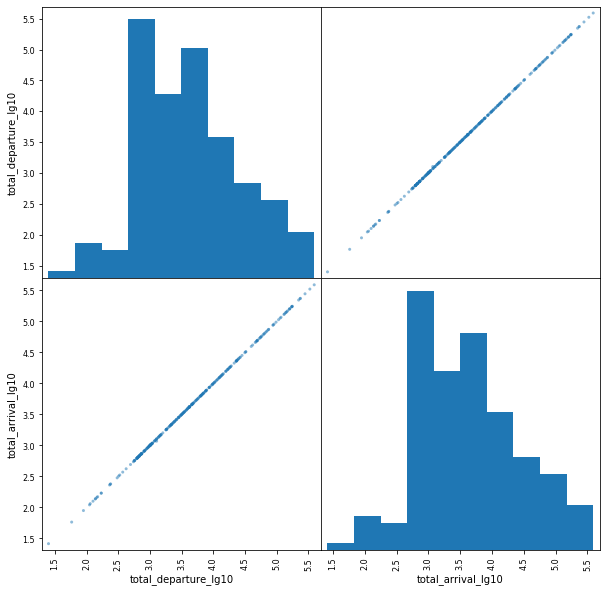

In [29]:
fig = pd.plotting.scatter_matrix(dep_arr_corr_df.loc[:,["total_departure_lg10","total_arrival_lg10"]],figsize=(10,10))

In [30]:
dep_arr_corr_df.loc[:,["total_departure_lg10","total_arrival_lg10"]].corr()

,total_departure_lg10,total_arrival_lg10
total_departure_lg10,1.000000,0.999996
total_arrival_lg10,0.999996,1.000000


By the above corrolation value, there's a nearly perfectly corrolated relationship between total departure count and total arrival count.This is logical: every plane that went into an airport must come out. **Therefore, a (almost) perfect linear relationship indicates the dataset captures flights completely. There's no airport with biased departure and arrival recording in this dataset, or, outliers**.  

In [31]:
alpha = 0.01
st_dep,p_dep = stats.normaltest(dep_arr_corr_df["total_departure_lg10"].values)
st_arr,p_arr = stats.normaltest(dep_arr_corr_df["total_arrival_lg10"].values)
print("P-value for departure_lg10 is :\t",p_dep,"is it normal under alpha =",alpha,"? - ",p_dep>alpha)
print("P-value for arrival_lg10 is :\t",p_arr,"is it normal under alpha =",alpha,"? - ",p_arr>alpha)

P-value for departure_lg10 is :	 0.040269406560878226 is it normal under alpha = 0.01 ? -  True
P-value for arrival_lg10 is :	 0.038080793944512116 is it normal under alpha = 0.01 ? -  True


They are:
- Linear related: corrolation near 1
- Normally distributed: as tested
- Homoscedasic: the graph looks consistent
- Not auto-corrolated: although arrival depends on departure, but departure value in one airport is unlikely to affect the departure value of another airport.
- Multicollinearity: this is not a multivariate regression

Therefore we can conduct a linear regression to see is there's a biased departure and arrival recording. This is different from above: no outliers indicated no individual airport have significently different departure / arrival ratio from other airports. Now we want to test is the ratio 1.

In [32]:
outcome_1,predictors_1 = patsy.dmatrices('total_arrival_lg10 ~ total_departure_lg10',dep_arr_corr_df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:     total_arrival_lg10   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.742e+07
Date:                Sun, 08 Mar 2020   Prob (F-statistic):               0.00
Time:                        23:49:08   Log-Likelihood:                 1453.2
No. Observations:                 312   AIC:                            -2902.
Df Residuals:                     310   BIC:                            -2895.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0004 

The effect size is **0.9999**. i.e. For any increase in log10(departure), we have >0.975 confidence that there will be 0.9999 \* that amount of increase in log10(arrival). **Departure and arrival is not biased.** However, they're also not identical: the intercept is 0.0004, which shows arrival value is slightly greater then departure. This is also logical: a plane must arrive before it can depart, but it can rest in a airport for a short amount of time before departing. This dataset contains data for 2018. If the plane arrives at 2018 and leaves not until 2009, there will be a net arrival surplus. Afterall, this number is small enough to ignore.

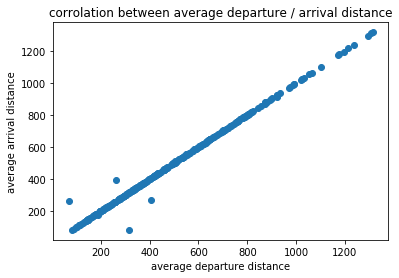

In [33]:
fig1 = plt.scatter(dep_arr_corr_df["averge_departure_distance"],dep_arr_corr_df["averge_arrival_distance"])
plt.title("corrolation between average departure / arrival distance")
plt.xlabel("average departure distance")
plt.ylabel("average arrival distance");

There's an overall linear relationship between average departure and arrival distance. This could be explained by "for any pair of cities, there often exists airlines that goto and come back from destination." 

Corrolation:  0.6304324907623623


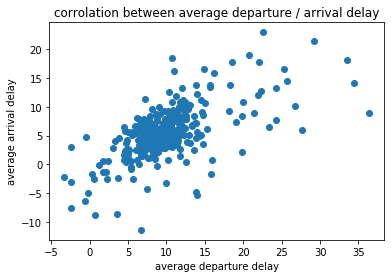

In [34]:
fig1 = plt.scatter(dep_arr_corr_df["average_departure_delay"],dep_arr_corr_df["average_arrival_delay"])
plt.title("corrolation between average departure / arrival delay")
plt.xlabel("average departure delay")
plt.ylabel("average arrival delay");
print("Corrolation: ",np.corrcoef(dep_arr_corr_df["average_departure_delay"],dep_arr_corr_df["average_arrival_delay"])[1][0])

Departure delay and arrival delay is weakly corrolated. Therefore, we need to analyze departure delay and arrival delay separately.  

### Geospatial distribution
Are our predictor variables corrolated with location? Are our outcome variables corrolated with location? In other words, is location the covariate behind possible corrolation between our predictor variables and airline delay?

In [80]:
def generate_bubble_map(df,column,limits,color,title,scale=1):

    if not (column in df.columns):
        print("column \""+column+"\"","not found in dataframe")
        return
    
    if not ('longitude' in df.columns and 'latitude' in df.columns):
        print("longitude or latitude not present in df")
        return
    
    try:
        n = int(limits) + 1
        lims = np.linspace(df[column].min()-abs(df[column].min())*0.001,df[column].max() + abs(df[column].max())*0.001,n)
        # subtract / add a small number to aviod rouding error that will left out max / min
        limits = list()
        for i in range(n):
            limits.append((lims[i],lims[i+1]))
        
    except:
        _ = 0 # do nothing
    
    
    if not (limits[0][0] <= df[column].min()):
        print("lower limit is higher then some of the rows")
        print("df[" + column + "].min()=",df[column].min())
    
    if not (limits[len(limits)-1][1] >= df[column].max()):
        print("upper limit is lower then some of the rows")
        print("df[" + column + "].max()=",df[column].max())
    
    #preprocess color
    colorseries={
        "blue":["#f7fbff", "#ebf3fb", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
                "#85bcdb", "#6baed6", "#57a0ce", "#3082be", "#2171b5", "#1361a9",
                "#08519c", "#0b4083", "#08306b"],
        "gray":["#ffffff","#eeeeee","#dddddd","#cccccc","#bbbbbb","#aaaaaa","#999999","#888888"],
        "thermal":["#00000a","#000014","#00001e","#000025","#00002a","#00002e","#000032","#000036","#00003a","#00003e","#000042","#000046","#00004a","#00004f","#000052","#010055","#010057","#020059","#02005c","#03005e","#040061","#040063","#050065","#060067","#070069","#08006b","#09006e","#0a0070","#0b0073","#0c0074","#0d0075","#0d0076","#0e0077","#100078","#120079","#13007b","#15007c","#17007d","#19007e","#1b0080","#1c0081","#1e0083","#200084","#220085","#240086","#260087","#280089","#2a0089","#2c008a","#2e008b","#30008c","#32008d","#34008e","#36008e","#38008f","#390090","#3b0091","#3c0092","#3e0093","#3f0093","#410094","#420095","#440095","#450096","#470096","#490096","#4a0096","#4c0097","#4e0097","#4f0097","#510097","#520098","#540098","#560098","#580099","#5a0099","#5c0099","#5d009a","#5f009a","#61009b","#63009b","#64009b","#66009b","#68009b","#6a009b","#6c009c","#6d009c","#6f009c","#70009c","#71009d","#73009d","#75009d","#77009d","#78009d","#7a009d","#7c009d","#7e009d","#7f009d","#81009d","#83009d","#84009d","#86009d","#87009d","#89009d","#8a009d","#8b009d","#8d009d","#8f009c","#91009c","#93009c","#95009c","#96009b","#98009b","#99009b","#9b009b","#9c009b","#9d009b","#9f009b","#a0009b","#a2009b","#a3009b","#a4009b","#a6009a","#a7009a","#a8009a","#a90099","#aa0099","#ab0099","#ad0099","#ae0198","#af0198","#b00198","#b00198","#b10197","#b20197","#b30196","#b40296","#b50295","#b60295","#b70395","#b80395","#b90495","#ba0495","#ba0494","#bb0593","#bc0593","#bd0593","#be0692","#bf0692","#bf0692","#c00791","#c00791","#c10890","#c10990","#c20a8f","#c30a8e","#c30b8e","#c40c8d","#c50c8c","#c60d8b","#c60e8a","#c70f89","#c81088","#c91187","#ca1286","#ca1385","#cb1385","#cb1484","#cc1582","#cd1681","#ce1780","#ce187e","#cf187c","#cf197b","#d01a79","#d11b78","#d11c76","#d21c75","#d21d74","#d31e72","#d32071","#d4216f","#d4226e","#d5236b","#d52469","#d62567","#d72665","#d82764","#d82862","#d92a60","#da2b5e","#da2c5c","#db2e5a","#db2f57","#dc2f54","#dd3051","#dd314e","#de324a","#de3347","#df3444","#df3541","#df363d","#e0373a","#e03837","#e03933","#e13a30","#e23b2d","#e23c2a","#e33d26","#e33e23","#e43f20","#e4411d","#e4421c","#e5431b","#e54419","#e54518","#e64616","#e74715","#e74814","#e74913","#e84a12","#e84c10","#e84c0f","#e94d0e","#e94d0d","#ea4e0c","#ea4f0c","#eb500b","#eb510a","#eb520a","#eb5309","#ec5409","#ec5608","#ec5708","#ec5808","#ed5907","#ed5a07","#ed5b06","#ee5c06","#ee5c05","#ee5d05","#ee5e05","#ef5f04","#ef6004","#ef6104","#ef6204","#f06303","#f06403","#f06503","#f16603","#f16603","#f16703","#f16803","#f16902","#f16a02","#f16b02","#f16b02","#f26c01","#f26d01","#f26e01","#f36f01","#f37001","#f37101","#f37201","#f47300","#f47400","#f47500","#f47600","#f47700","#f47800","#f47a00","#f57b00","#f57c00","#f57e00","#f57f00","#f68000","#f68100","#f68200","#f78300","#f78400","#f78500","#f78600","#f88700","#f88800","#f88800","#f88900","#f88a00","#f88b00","#f88c00","#f98d00","#f98d00","#f98e00","#f98f00","#f99000","#f99100","#f99200","#f99300","#fa9400","#fa9500","#fa9600","#fb9800","#fb9900","#fb9a00","#fb9c00","#fc9d00","#fc9f00","#fca000","#fca100","#fda200","#fda300","#fda400","#fda600","#fda700","#fda800","#fdaa00","#fdab00","#fdac00","#fdad00","#fdae00","#feaf00","#feb000","#feb100","#feb200","#feb300","#feb400","#feb500","#feb600","#feb800","#feb900","#feb900","#feba00","#febb00","#febc00","#febd00","#febe00","#fec000","#fec100","#fec200","#fec300","#fec400","#fec500","#fec600","#fec700","#fec800","#fec901","#feca01","#feca01","#fecb01","#fecc02","#fecd02","#fece03","#fecf04","#fecf04","#fed005","#fed106","#fed308","#fed409","#fed50a","#fed60a","#fed70b","#fed80c","#fed90d","#ffda0e","#ffda0e","#ffdb10","#ffdc12","#ffdc14","#ffdd16","#ffde19","#ffde1b","#ffdf1e","#ffe020","#ffe122","#ffe224","#ffe226","#ffe328","#ffe42b","#ffe42e","#ffe531","#ffe635","#ffe638","#ffe73c","#ffe83f","#ffe943","#ffea46","#ffeb49","#ffeb4d","#ffec50","#ffed54","#ffee57","#ffee5b","#ffee5f","#ffef63","#ffef67","#fff06a","#fff06e","#fff172","#fff177","#fff17b","#fff280","#fff285","#fff28a","#fff38e","#fff492","#fff496","#fff49a","#fff59e","#fff5a2","#fff5a6","#fff6aa","#fff6af","#fff7b3","#fff7b6","#fff8ba","#fff8bd","#fff8c1","#fff8c4","#fff9c7","#fff9ca","#fff9cd","#fffad1","#fffad4","#fffbd8","#fffcdb","#fffcdf","#fffde2","#fffde5","#fffde8","#fffeeb","#fffeee","#fffef1","#fffef4","#fffff6"],
        "black":["#bbbbbb","#aaaaaa","#999999","#888888","#777777","#666666","#555555","#444444","#333333","#222222","#111111","#000000"]
    }
    colors = list()
    inds = list(np.linspace(0,len(colorseries[color])-1,len(limits)).astype("int"))
    for i in inds:
        colors.append(colorseries[color][i])
        
    scale *= 250 / (df[column].max() - df[column].min())
    
    fig = go.Figure()
    for i in range(len(limits)):
        lim = limits[i]
        df_sub = df[(lim[0]<=df[column]) & (df[column]<lim[1])]
        fig.add_trace(go.Scattergeo(
            locationmode = 'USA-states',
            lon = df_sub['longitude'],
            lat = df_sub['latitude'],
            text = df_sub.index,
            marker = dict(
                size = (df_sub[column] - df[column].min())*scale, # ensure size is positive
                color = colors[i],
                line_color='rgb(40,40,40)',
                line_width=0,
                sizemode = 'area'
            ),
            name = '{0:.3g} - {1:.3g}'.format(lim[0],lim[1])))

    fig.update_layout(
            title_text = title,
            showlegend = True,
            geo = dict(
                scope = 'usa',
                landcolor = 'rgb(217, 217, 217)',
            )
        )
    return fig

### Outcome variables

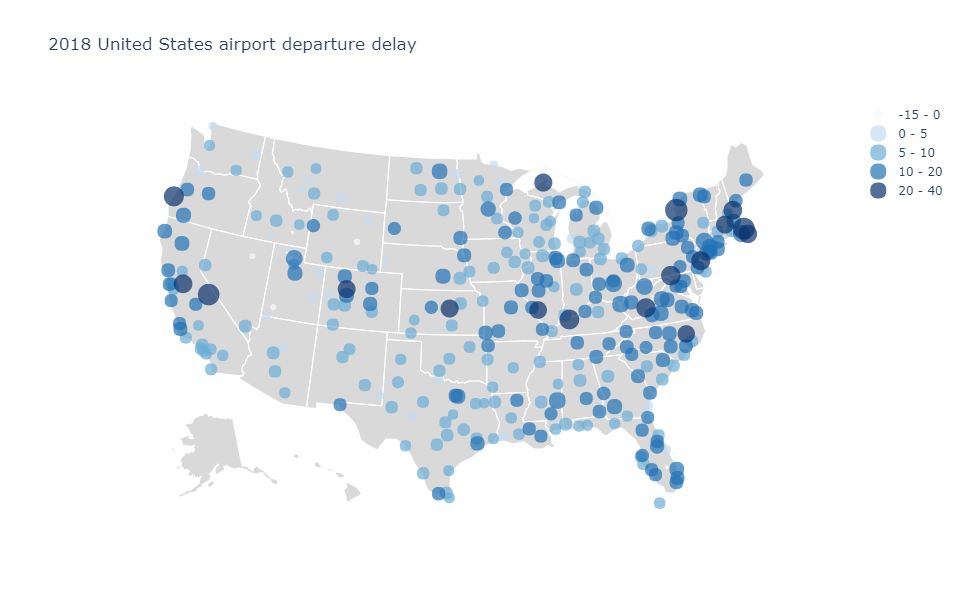

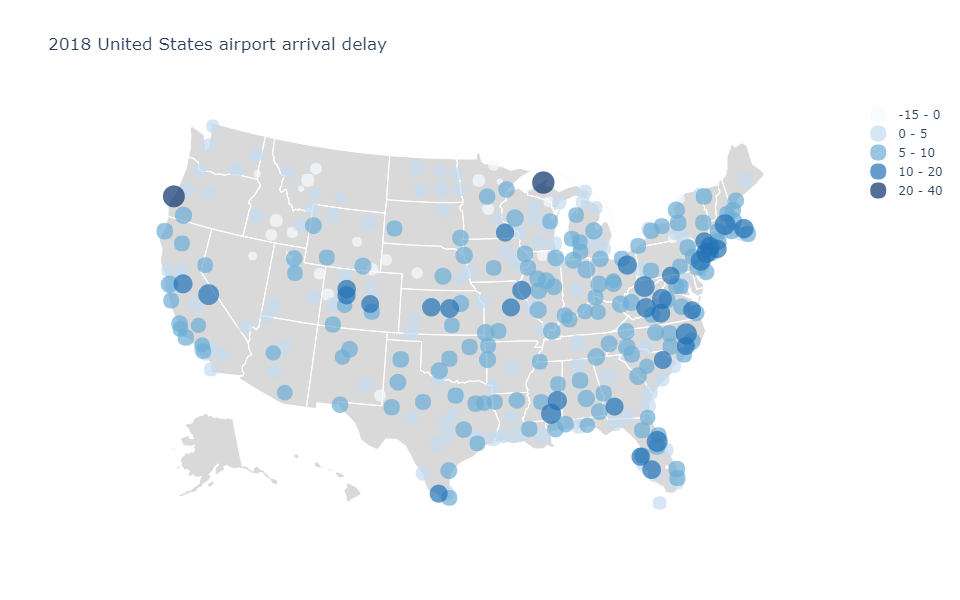

In [81]:
fig1 = generate_bubble_map(Y.merge(merged_X_df[["latitude","longitude"]],left_index=True,right_index=True),
                          column="average_departure_delay",
                          limits=[(-15,0),(0,5),(5,10),(10,20),(20,40)],
                          color="blue",
                          title='2018 United States airport departure delay')
#fig1.show()
fig1.write_image("images/dep_delay.png",width=960,height=600)
fig2 = generate_bubble_map(Y.merge(merged_X_df[["latitude","longitude"]],left_index=True,right_index=True),
                          column="average_arrival_delay",
                          limits=[(-15,0),(0,5),(5,10),(10,20),(20,40)],
                          color="blue",
                          title='2018 United States airport arrival delay')
#fig2.show()
fig2.write_image("images/arr_delay.png",width=960,height=600)
display(Image(filename='images/dep_delay.png'))
display(Image(filename='images/arr_delay.png'))

From the above figure, we can see the following information
- Arrival delay is overall less then departure delay
    - When delayed by the originating airport, pilots would typically cruise at a faster speed to catch up with the schedule.
    
    
- Triangular region(From center of Nevada to U.S. - Canadian boarder) in the upper left region have less departure and arrival delay. 
    - Need to find out what variable is corrolated with this region
    
    
- Both departure / arrival delay distributed along ocean.

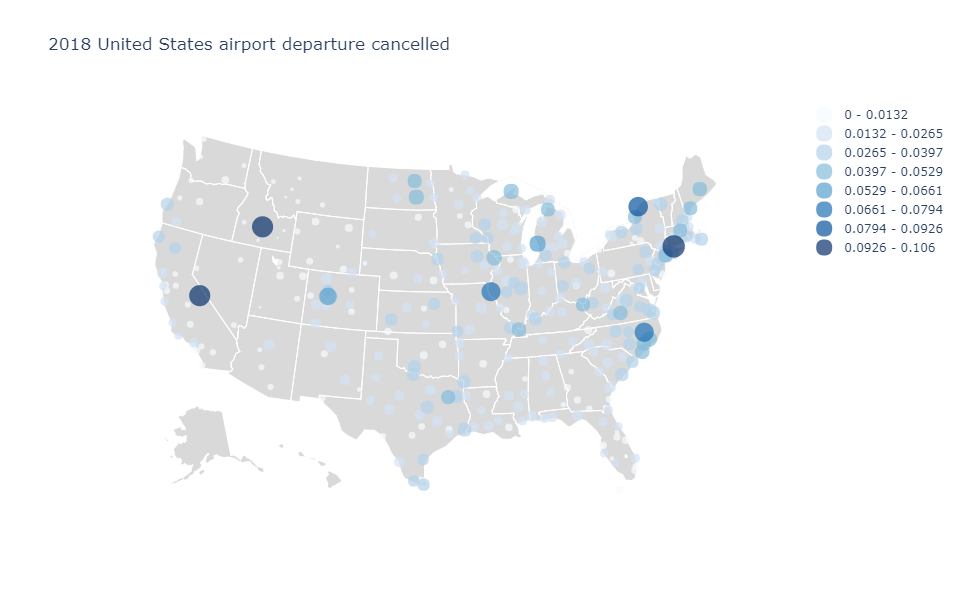

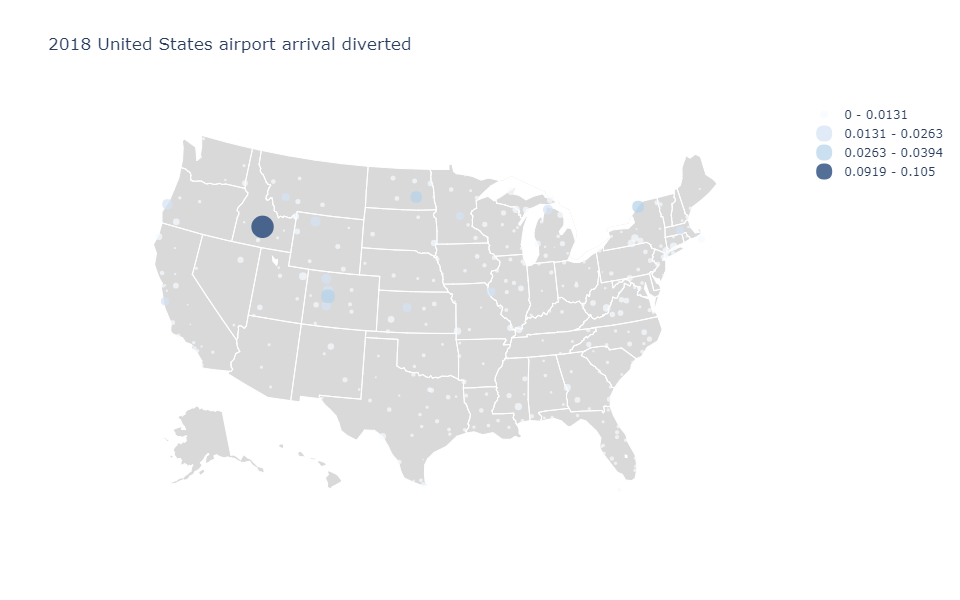

In [82]:
fig1 = generate_bubble_map(Y.merge(merged_X_df[["latitude","longitude"]],left_index=True,right_index=True),
                          column="average_departure_cancelled",
                          limits=8,
                          color="blue",
                          title='2018 United States airport departure cancelled')
#fig1.show()
fig1.write_image("images/dep_cancel.png",width=960,height=600)
fig2 = generate_bubble_map(Y.merge(merged_X_df[["latitude","longitude"]],left_index=True,right_index=True),
                          column="average_arrival_diverted",
                          limits=8,
                          color="blue",
                          title='2018 United States airport arrival diverted')
#fig2.show()
fig2.write_image("images/arr_divert.png",width=960,height=600)
display(Image(filename='images/dep_cancel.png'))
display(Image(filename='images/arr_divert.png'))

- East coast have greater cancel rate, cancel rate may be correlated with longitude.


- There's a outlier of divert rate in state Idaho

In [96]:
# The outlier:
merged_X_df[Y["average_arrival_diverted"]==Y["average_arrival_diverted"].max()]

,total_departure,total_arrival,total_departure_lg10,total_arrival_lg10,averge_departure_distance,averge_arrival_distance,average_departure_taxi,average_arrival_taxi,city_name,code4,...,fips,population,temp_avg,pcp_avg,strike_avg,damage_avg,enplanements,length_ft_sum,width_ft_avg,runway_count
SUN,1274.0,1277.0,3.105169,3.106191,334.876766,334.637431,15.435009,2.807292,hailey,KSUN,...,16013,10875,42.675934,1.472988,0.25,0.0,133281.0,6952.0,100.0,1.0


The outlier have reasonable enplanements: 133281. And we inspected the raw data, there's no nan for cancelled. Therefore we can't remove it from our while dataset. However, there must be some sepcific reason behiend this airport that does not adhere to overall trend. We re-plotted a map with SUN removed(but not from original dataset!)

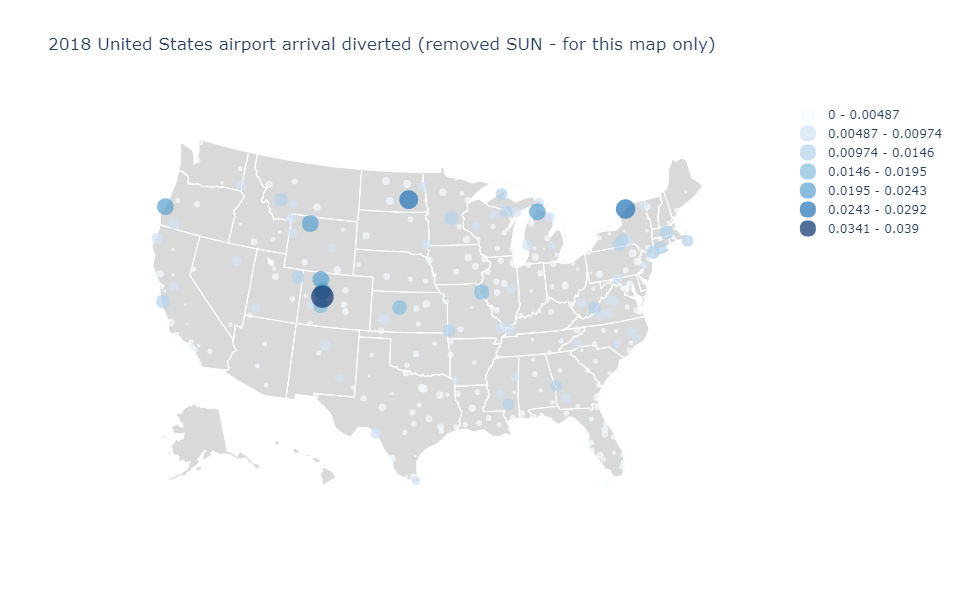

In [117]:
fig2 = generate_bubble_map(Y.merge(merged_X_df[["latitude","longitude"]],left_index=True,right_index=True).drop("SUN",axis=0),
                          column="average_arrival_diverted",
                          limits=8,
                          color="blue",
                          title='2018 United States airport arrival diverted (removed SUN - for this map only)')
#fig2.show()
fig2.write_image("images/arr_divert_rm_outlier.png",width=960,height=600)

display(Image(filename='images/arr_divert_rm_outlier.png'))

### Predictor variables

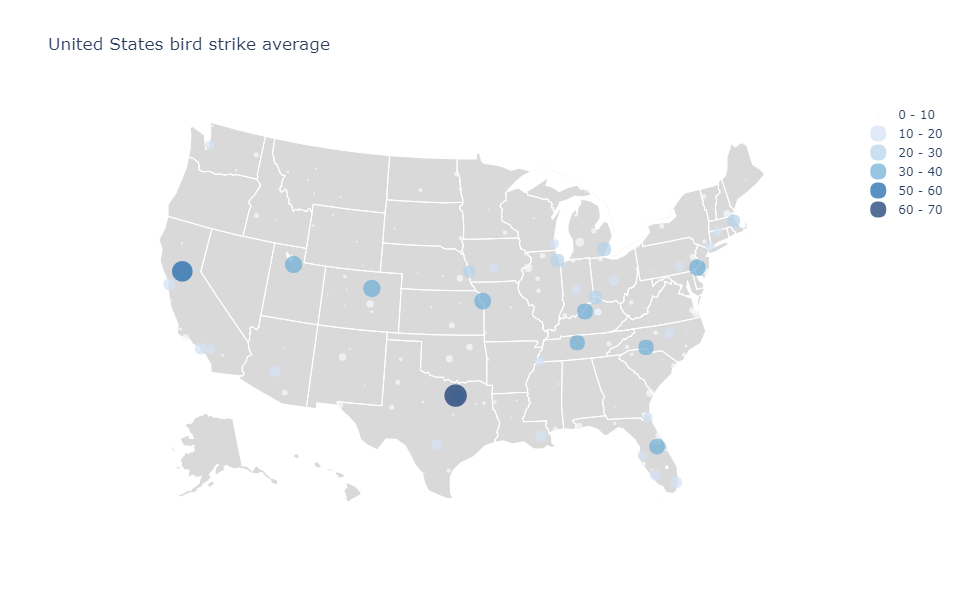

In [37]:
fig = generate_bubble_map(merged_X_df,
                          column="strike_avg",
                          limits=[(0,10),(10,20),(20,30),(30,40),(40,50),(50,60),(60,70)],
                          color="blue",
                          title='United States bird strike average')
fig.write_image("images/bird.png",width=960,height=600)
display(Image(filename='images/bird.png'))

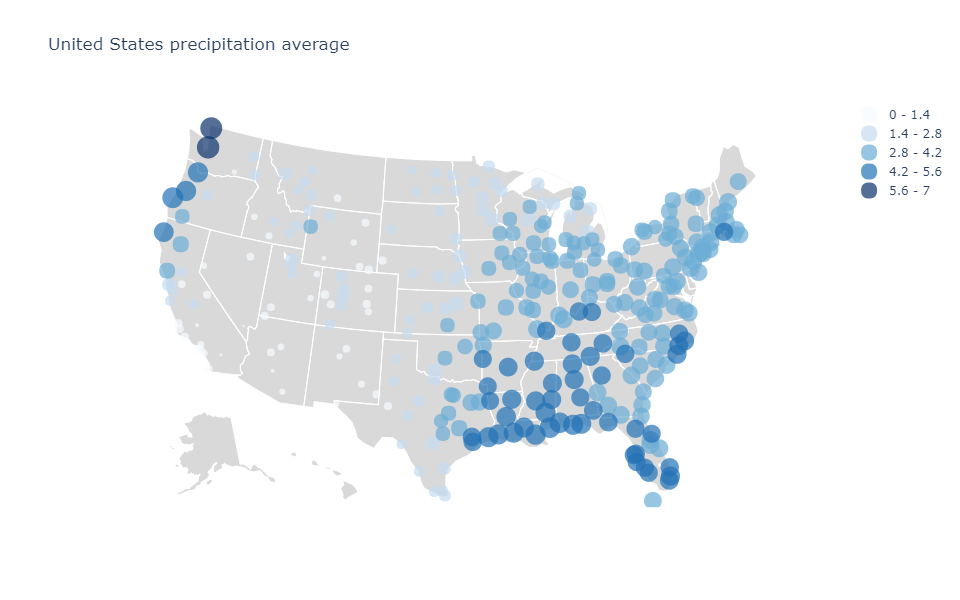

In [67]:
fig = generate_bubble_map(merged_X_df,
                          column="pcp_avg",
                          limits=[(0,1.4),(1.4,2.8),(2.8,4.2),(4.2,5.6),(5.6,7.0)],
                          color="blue",
                          title='United States precipitation average')
#fig.show()
fig.write_image("images/pcp.png",width=960,height=600)
display(Image(filename='images/pcp.png'))

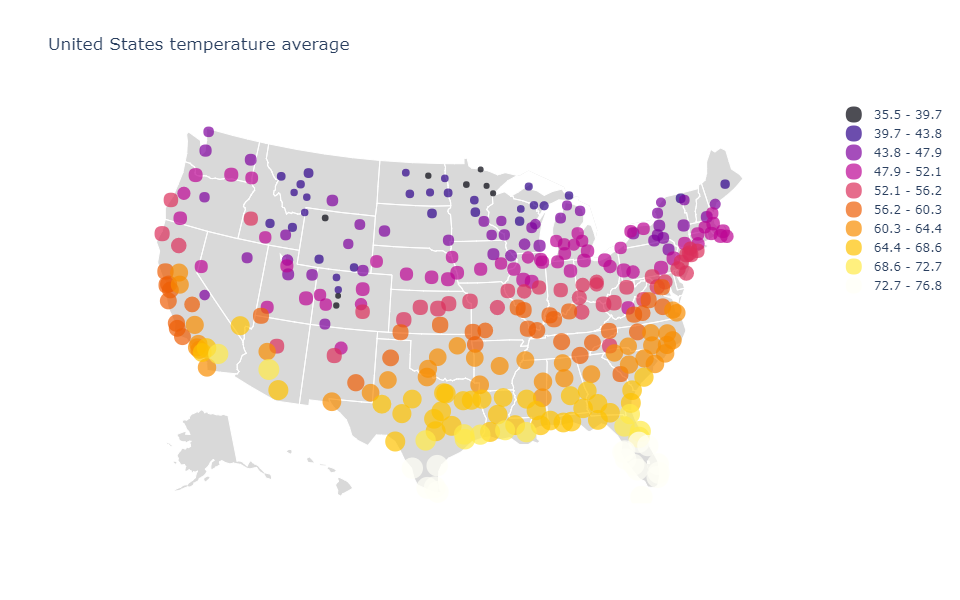

In [118]:
fig = generate_bubble_map(merged_X_df,
                          column="temp_avg",
                          limits=10,
                          color="thermal",
                          title='United States temperature average')
fig.write_image("images/temp.png",width=960,height=600)
display(Image(filename='images/temp.png'))

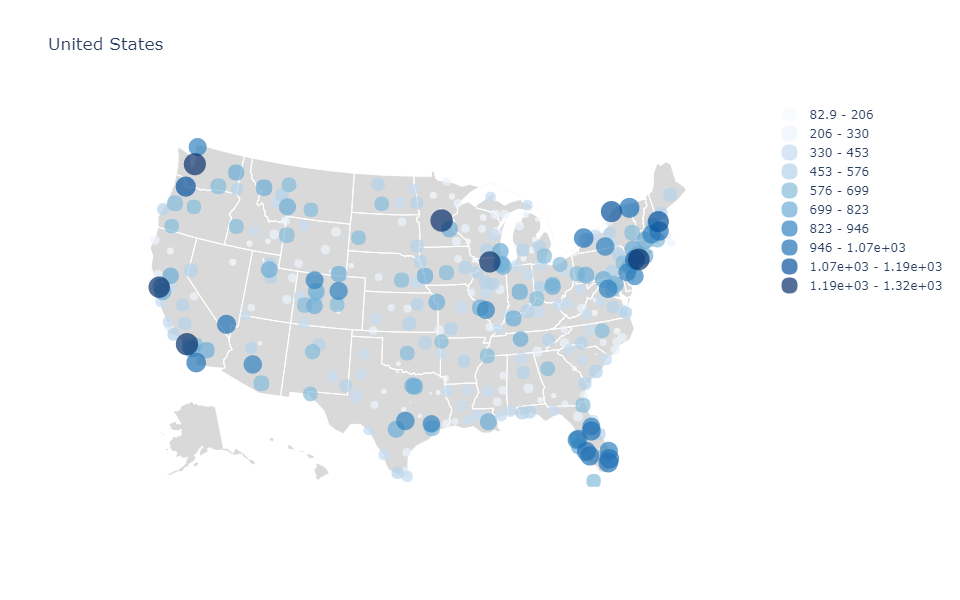

In [132]:
fig = generate_bubble_map(merged_X_df,
                          column="averge_arrival_distance",
                          limits=10,
                          color="blue",
                          title='United States')
fig.write_image("images/test.png",width=960,height=600)
display(Image(filename='images/test.png'))

In [122]:
merged_X_df.columns

Index(['total_departure', 'total_arrival', 'total_departure_lg10',
       'total_arrival_lg10', 'averge_departure_distance',
       'averge_arrival_distance', 'average_departure_taxi',
       'average_arrival_taxi', 'city_name', 'code4', 'latitude', 'longitude',
       'altitude_ft', 'city_id', 'fips', 'population', 'temp_avg', 'pcp_avg',
       'strike_avg', 'damage_avg', 'enplanements', 'length_ft_sum',
       'width_ft_avg', 'runway_count'],
      dtype='object')

## Analysis

# Ethics & Privacy

Ethics here

# Conclusion

Conclusion here